# Тестовое задание
 
В прикрепленном файле data_train.csv вам предоставлены почасовые данные потребления электроэнергии одного из предприятий (c 1.01.2019 по 8.09.2019). Постройте почасовой прогноз потребления с 9.09.2019 по 22.09.2019. В качестве метрики используйте RMSE. Оформите на языке Python в Jupyter Notebook выбор модели, подбор параметров и построение прогноза. Можно пользоваться любыми библиотеками. Также, предоставьте файл с прогнозами в формате csv. 

In [411]:
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
import statsmodels.api as sm
from itertools import product
from warnings import filterwarnings
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
filterwarnings('ignore')

In [412]:
time_series = pd.read_csv('data_train_NNFormat.csv', index_col=['timestamp'], parse_dates=['timestamp'], dayfirst=True)
time_series.head()

,fact
timestamp,
2019-01-01 00:00:00,294.0
2019-01-01 01:00:00,292.0
2019-01-01 02:00:00,290.0
2019-01-01 03:00:00,293.0
2019-01-01 04:00:00,294.0


<AxesSubplot:xlabel='timestamp'>

<Figure size 1080x216 with 0 Axes>

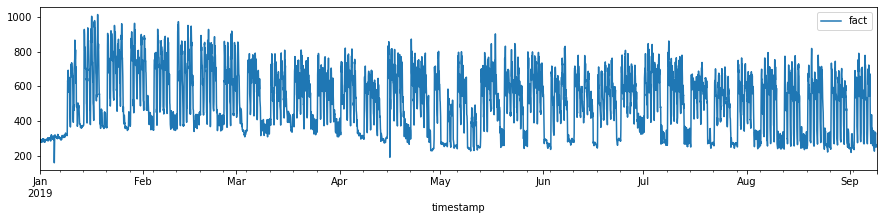

In [413]:
plt.figure(figsize(15, 3))
time_series.plot()

<Figure size 1080x720 with 0 Axes>

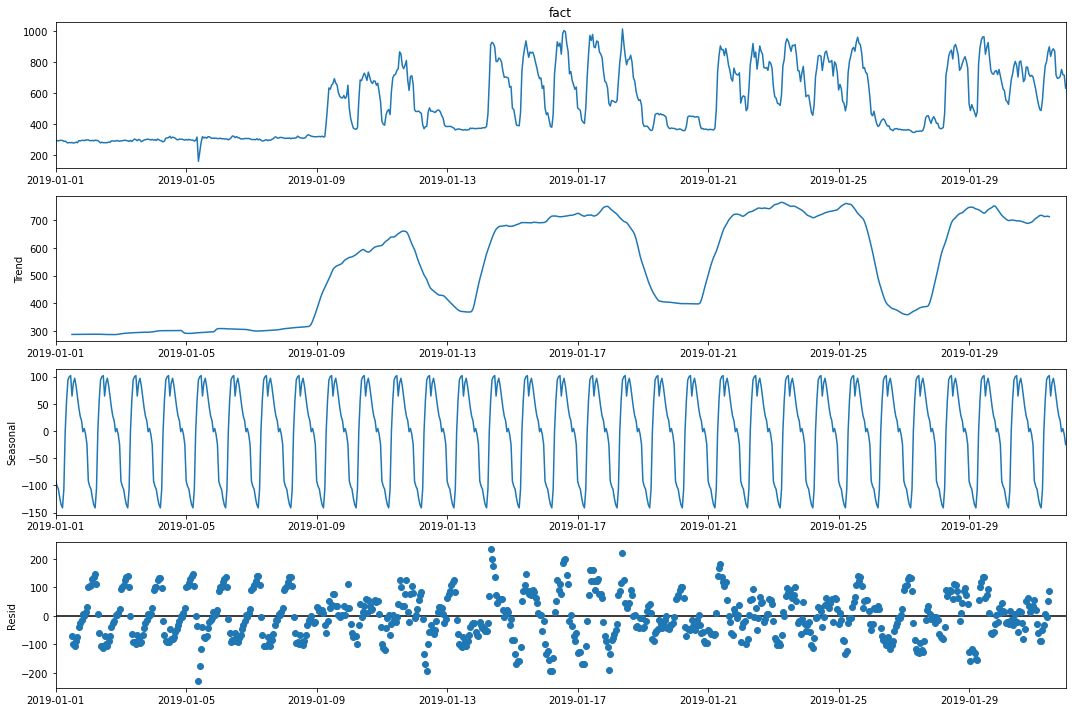

In [414]:
plt.figure(figsize(15, 10))
sm.tsa.seasonal_decompose(time_series['20190101':'20190131'].fact).plot();

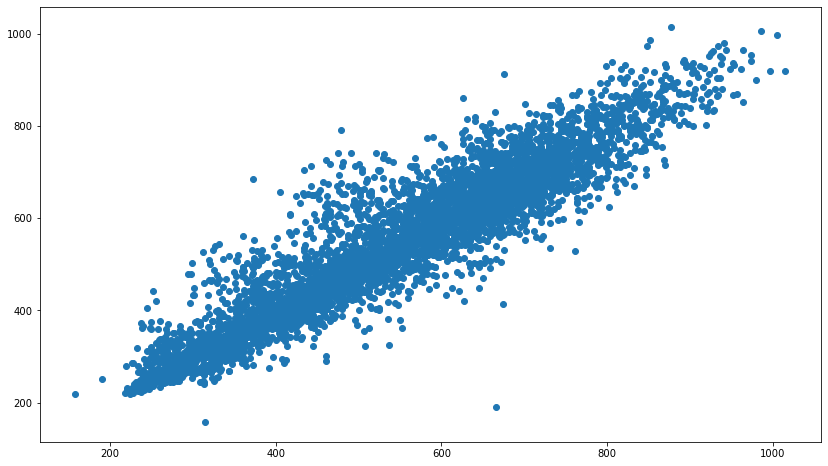

In [415]:
i = 1
plt.figure(figsize(14, 8))
plt.scatter(time_series.iloc[:-i], time_series[i:])

-9.128466563383425
3.0677081578335823e-15
24
2326
{'1%': -3.4331645018756975, '5%': -2.8627833910976266, '10%': -2.5674319121464415}
24026.69120808947


<AxesSubplot:xlabel='timestamp'>

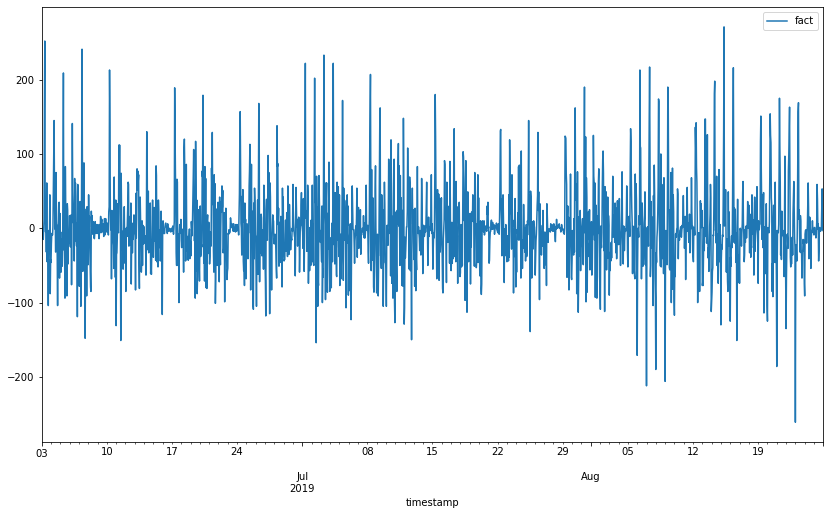

In [416]:
train_st, train_end = '20190603','20190825'
test_st, test_end = '20190826', '20190908'
# train_ts = ts[train_st:].diff(24)
# train_ts = train_ts.diff()
train_ts = time_series[train_st:].diff()

print(*sm.tsa.stattools.adfuller(train_ts.fact.dropna()), sep='\n')
train_ts, test_ts = train_ts[:train_end], train_ts[test_st:]
train_ts.plot()

<Figure size 1152x576 with 0 Axes>

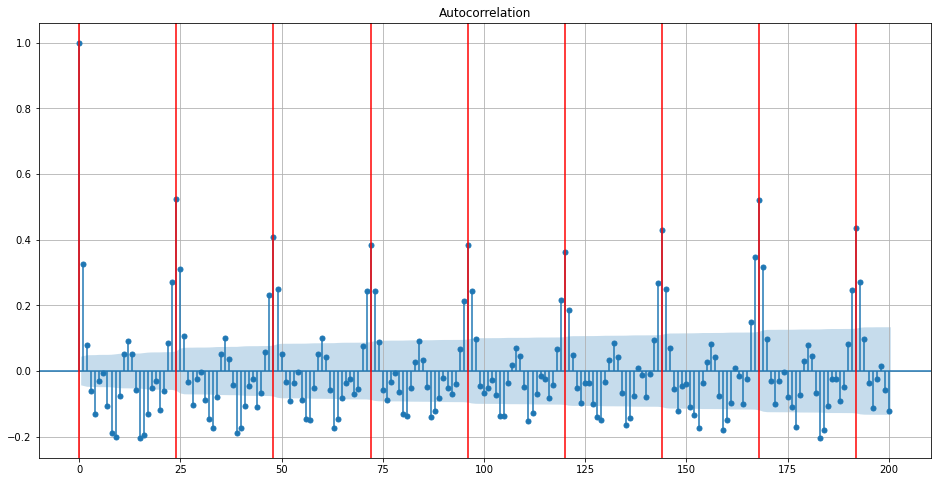

In [386]:
m = 200
plt.figure(figsize(16, 8))
sm.graphics.tsa.plot_acf(train_ts.dropna().values.squeeze(), lags=m);
plt.grid(True)
for i in range(0, m, 24):
    plt.axvline(i, color='r')

<Figure size 1152x576 with 0 Axes>

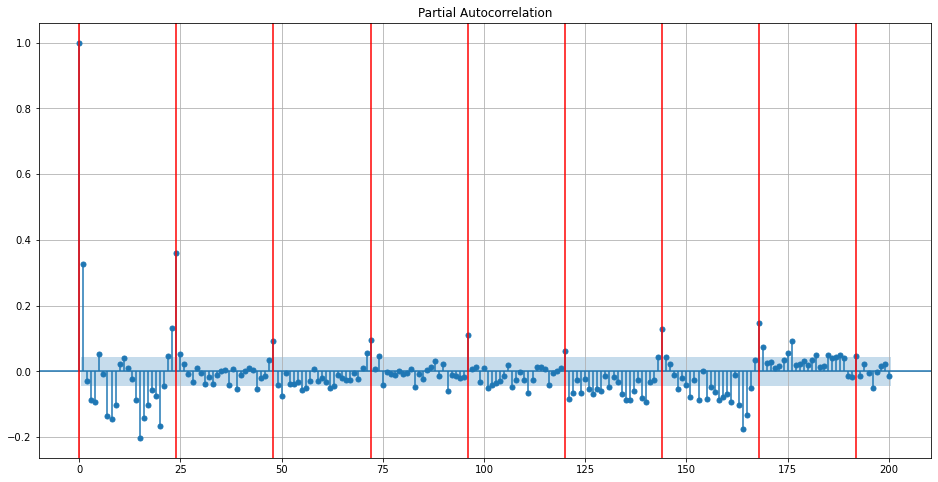

In [387]:
m = 200
plt.figure(figsize(16, 8))
sm.graphics.tsa.plot_pacf(train_ts.dropna().values.squeeze(), lags=m);
plt.grid(True)
for i in range(0, m, 24):
    plt.axvline(i, color='r')

In [422]:
Q = 7
q = 9
P = 1 # 7
p = 8
ps = qs = Ps = Qs = range(4)
d, D = 1, 1
params = list(product(ps, qs, Ps, Qs))
len(params)

256

In [35]:
results = []
best_aic = -1
filterwarnings('ignore')

for param in tqdm(params):
    if any([p == 3 for p in param]):
        try:

            model = sm.tsa.statespace.SARIMAX(train_ts.dropna(), order=(param[0], d, param[1]),
                                              seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1, maxiter=100)
        except Exception:
            print('wrong params:', param)
            continue
        aic = model.aic
        if aic < best_aic or best_aic == -1:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
filterwarnings('default')

 12%|█████████▉                                                                     | 32/256 [10:26<1:57:42, 31.53s/it]

wrong params: (0, 1, 3, 3)


 62%|████████████████████████████████████████████████▊                             | 160/256 [1:35:02<53:54, 33.69s/it]

wrong params: (2, 1, 3, 3)


 69%|████████████████████████████████████████████████████▎                       | 176/256 [1:49:29<1:25:02, 63.78s/it]

wrong params: (2, 2, 3, 3)


 86%|██████████████████████████████████████████████████████████████████▋           | 219/256 [2:31:36<28:20, 45.95s/it]

wrong params: (3, 1, 2, 2)


100%|██████████████████████████████████████████████████████████████████████████████| 256/256 [3:55:12<00:00, 55.13s/it]


In [390]:
print(best_model.summary())

                                         SARIMAX Results                                          
Dep. Variable:                                       fact   No. Observations:                 2015
Model:             SARIMAX(2, 1, 2)x(0, 0, [1, 2, 3], 24)   Log Likelihood              -10541.663
Date:                                    Tue, 13 Jul 2021   AIC                          21099.325
Time:                                            10:55:41   BIC                          21144.188
Sample:                                        06-03-2019   HQIC                         21115.792
                                             - 08-25-2019                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8097      0.018    -46.046      0

(-13.53133359114187,
 2.618130389822296e-25,
 17,
 1997,
 {'1%': -3.4336287809345873,
  '5%': -2.862988387691722,
  '10%': -2.5675410598947996},
 20420.03619974172)

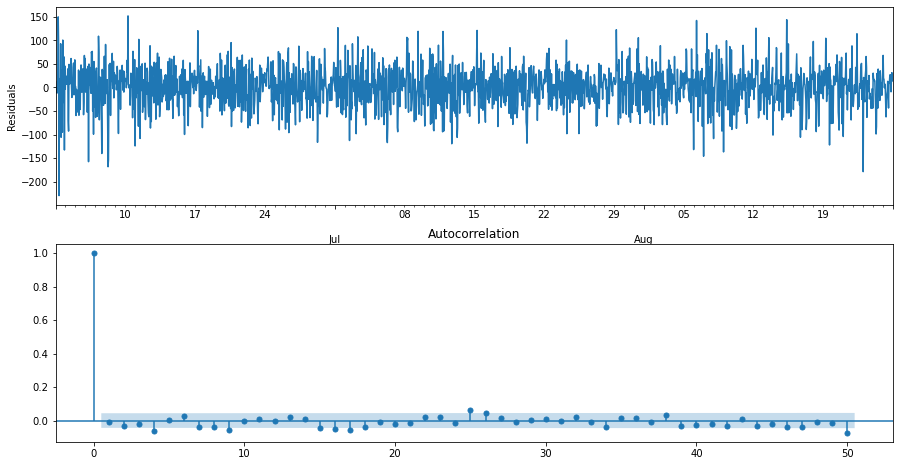

In [399]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid.dropna().plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid.dropna().values.squeeze(), lags=50, ax=ax)

sm.tsa.stattools.adfuller(best_model.resid.dropna())

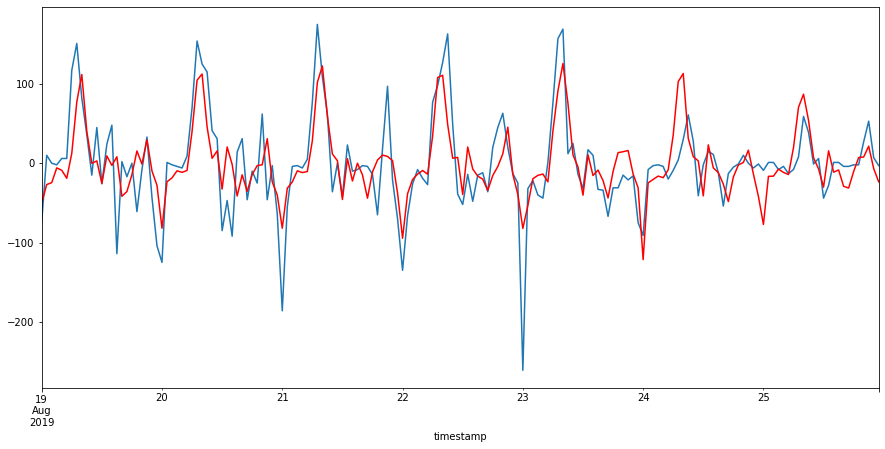

In [400]:
a, b = '20190819', '20190825'
plt.figure(figsize(15,7))
train_ts['arima'] = best_model.fittedvalues
train_ts.fact[a:b].plot()
train_ts.arima.dropna()[a:b].plot(color='r')
pylab.show()

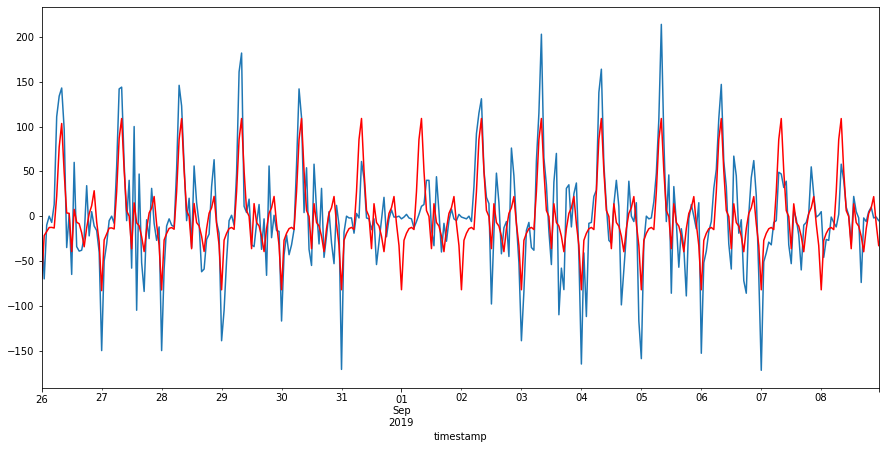

36.88327672970604

In [418]:
plt.figure(figsize(15,7))
test_ts['arima'] = best_model.predict(start=test_ts.index.min(), end=test_ts.index.max())
test_ts.fact.plot()
test_ts.arima.dropna().plot(color='r')
plt.show()
mean_squared_error(test_ts.dropna().fact, test_ts.dropna().arima, squared=False)

184.4729047521462

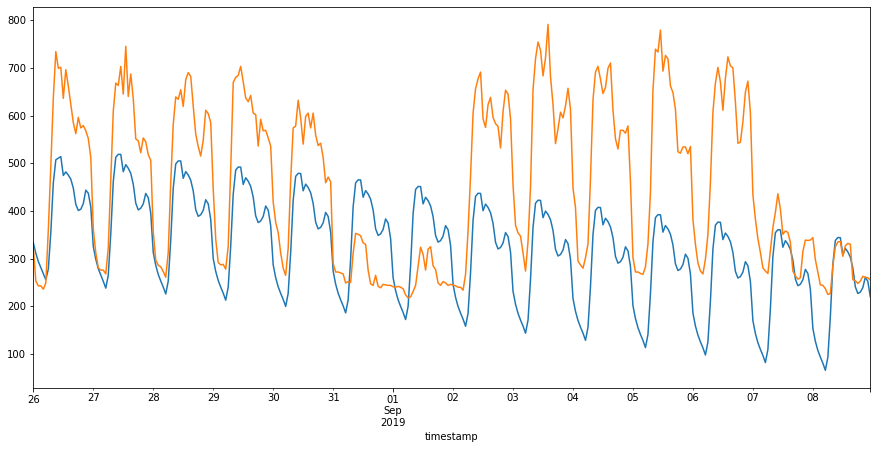

In [419]:
p = 1
test_ts['inverse'] = 0
inv_col = test_ts.columns.get_loc('inverse')
test_ts.iloc[0, inv_col] = time_series['20190825'].iloc[-1]['fact']
for i in range(p, len(test_ts)):
    test_ts.iloc[i, inv_col] = test_ts.iloc[i]['arima'] + test_ts.iloc[i - p]['inverse']
    
test_ts.inverse.plot()
time_series.loc[test_ts.index].fact.plot()
mean_squared_error(test_ts.inverse, time_series.loc[test_ts.index].fact, squared=False)

<AxesSubplot:xlabel='timestamp'>

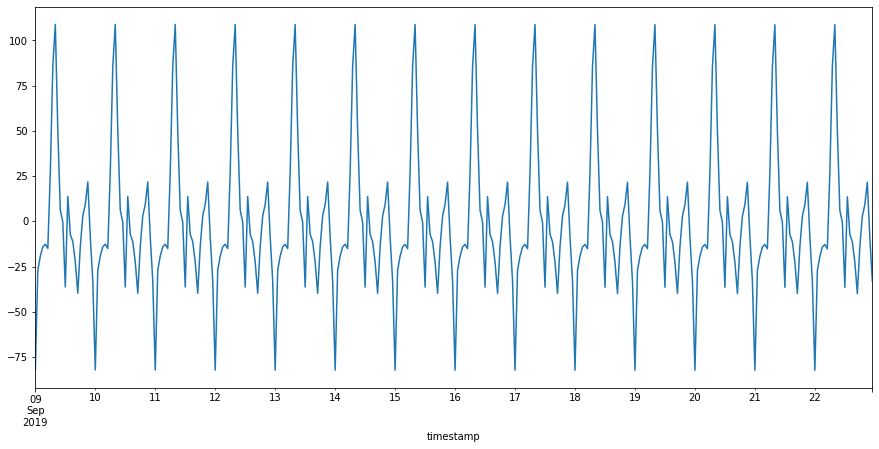

In [420]:
forecast_ts = pd.DataFrame({'timestamp':pd.date_range('20190909', '20190923', freq='1H', closed='left')})
forecast_ts.set_index('timestamp', inplace=True)
forecast_ts['arima'] = best_model.predict(start='20190909', end='20190923')
forecast_ts.arima.plot()

<AxesSubplot:xlabel='timestamp'>

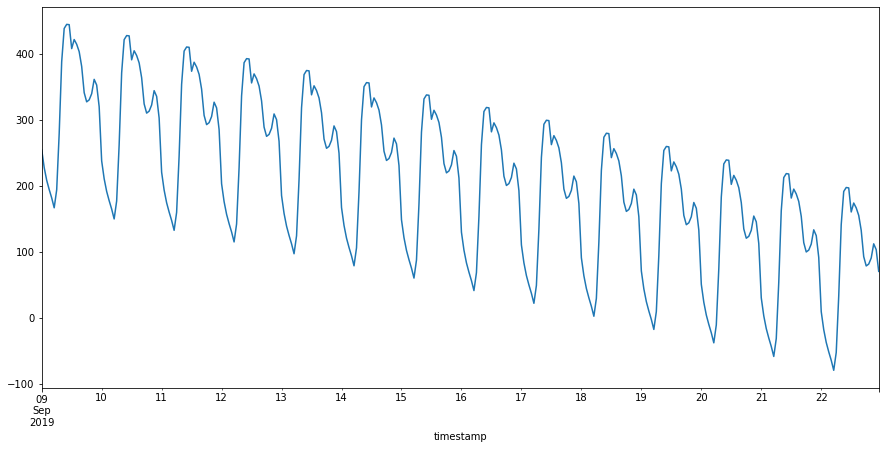

In [421]:
p = 1
forecast_ts['inverse'] = 0
inv_col = forecast_ts.columns.get_loc('inverse')
forecast_ts.iloc[0, inv_col] = time_series['2019-09-08'].iloc[-1]['fact']
for i in range(p, len(forecast_ts)):
    forecast_ts.iloc[i, inv_col] = forecast_ts.iloc[i]['arima'] + forecast_ts.iloc[i - p]['inverse']
    
forecast_ts.inverse.plot()